4.060920839758724e-05 0.12399839331166698 4.060920839758724e-05 1.0


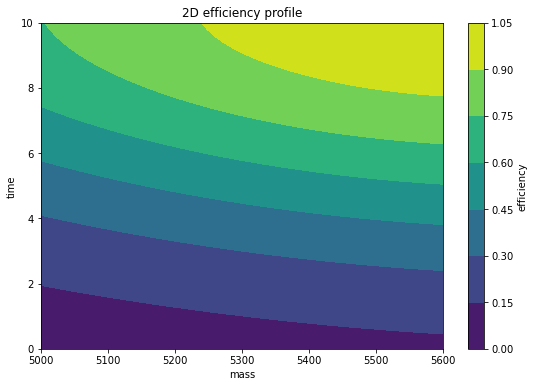

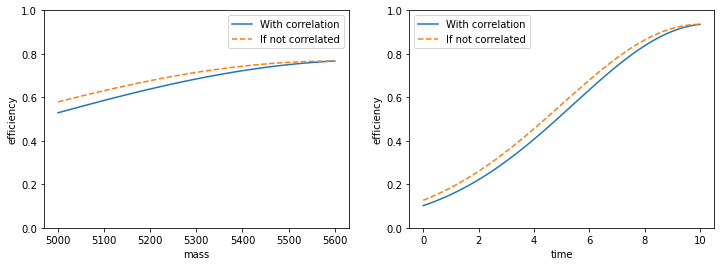

In [87]:
### We are now going to see what happens with the practical example when we introduce an efficiency term

import numpy as np
from scipy import stats
from scipy.stats import norm, expon, powerlaw, multivariate_normal
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from scipy.integrate import quad, nquad

np.random.seed(1)  # fix seed

# true parameters for signal and background
truth_n_sig = 500
truth_n_bkg = 2000

# signal mass gauss:(mean, sigma)
truth_sig_m = (5280, 30)
# background mass expo:(loc, scale)
truth_bkg_m = (5000,400,)
# signal time expo:(loc, scale)
truth_sig_t = (0, 2.0,)
# background time gauss:(mean, sigma)
truth_bkg_t = (0., 3.0)

# make the pdfs
sig_pdf_mass = norm(*truth_sig_m)
bkg_pdf_mass = expon(*truth_bkg_m)
sig_pdf_time = expon(*truth_sig_t)
bkg_pdf_time = norm(*truth_bkg_t)

# eff func
eff_means  = [ 5600, 10 ]
eff_sigmas = [ 800 , 5 ]
eff_corr = -0.2
eff_cov = [ [ eff_sigmas[0]**2, eff_corr*eff_sigmas[0]*eff_sigmas[1] ],
            [ eff_corr*eff_sigmas[0]*eff_sigmas[1], eff_sigmas[1]**2 ]
          ]

eff_pdf = multivariate_normal(eff_means, eff_cov)



# plot the pdfs
mrange = (5000,5600)
trange = (0,10)
mass = np.linspace(*mrange,50)
time = np.linspace(*trange,50)

fig, ax = plt.subplots(1,1,figsize=(9,6))
x,y = np.meshgrid(mass,time)
eff_norm = np.max( eff_pdf.pdf(np.dstack((x,y))) )

im = ax.contourf(x,y, eff_pdf.pdf(np.dstack((x,y)))/eff_norm)
cb = fig.colorbar(im, ax=ax)
ax.set_xlabel('mass')
ax.set_ylabel('time')
cb.set_label('efficiency')
ax.set_title("2D efficiency profile")

# for each mass value want to project the PDF so need it's expectation in the other dimension

fig, ax = plt.subplots(1,2,figsize=(12,4))
expected_ms = []
expected_ts = []

for m in mass:
    # get expectation value of t at given mass m
    exp_norm = quad( lambda t: eff_pdf.pdf([m,t]), *trange )[0]
    exp_val  = quad( lambda t: t*eff_pdf.pdf([m,t])/exp_norm, *trange )[0]
    expected_ts.append( exp_val )

for t in time:
    # get expectation value of m at given time t
    exp_norm = quad( lambda m: eff_pdf.pdf([m,t]), *mrange )[0]
    exp_val  = quad( lambda m: m*eff_pdf.pdf([m,t])/exp_norm, *mrange )[0]
    expected_ms.append( exp_val )
    
expected_ms = np.array( expected_ms )
expected_ts = np.array( expected_ts)

# make the relevant mesh
mass_w_texp = np.dstack((mass,expected_ts))
time_w_mexp = np.dstack((expected_ms,time))

ax[0].plot(mass, eff_pdf.pdf(mass_w_texp)/eff_norm,label='With correlation')
mcheck = norm(eff_means[0],eff_sigmas[0])
mcn = np.max(eff_pdf.pdf(mass_w_texp)/eff_norm) / np.max(mcheck.pdf(mass))
ax[0].plot(mass, mcn*mcheck.pdf(mass), '--', label='If not correlated')
ax[0].set_ylim(0,1)
ax[0].set_xlabel('mass')
ax[0].set_ylabel('efficiency')
ax[0].legend()


ax[1].plot(time, eff_pdf.pdf(time_w_mexp)/eff_norm,label='With correlation')
tcheck = norm(eff_means[1],eff_sigmas[1])
tcn = np.max(eff_pdf.pdf(time_w_mexp)/eff_norm) / np.max(tcheck.pdf(time))
ax[1].plot(time, tcn*tcheck.pdf(time), '--',label='If not correlated')
ax[1].set_ylim(0,1)
ax[1].set_xlabel('time')
ax[1].set_ylabel('efficiency')
ax[1].legend()



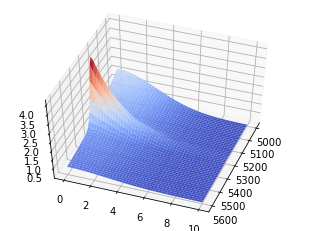

In [97]:
from matplotlib import gridspec
from matplotlib import cm

# get the normalisation for the range
sig_norm_mass = np.diff(sig_pdf_mass.cdf(mrange))
bkg_norm_mass = np.diff(bkg_pdf_mass.cdf(mrange))
sig_norm_time = np.diff(sig_pdf_time.cdf(trange))
bkg_norm_time = np.diff(bkg_pdf_time.cdf(trange))


### now plot the pdf with the efficiency included
def pdf(x, y, eff=True):
    sig_term = truth_n_sig * sig_pdf_mass.pdf(x)/sig_norm_mass * sig_pdf_time.pdf(y)/sig_norm_time
    bkg_term = truth_n_bkg * bkg_pdf_mass.pdf(x)/bkg_norm_mass * bkg_pdf_time.pdf(y)/bkg_norm_time
    sum_term = sig_term + bkg_term
    if eff: return eff_pdf.pdf(np.dstack((x,y)))/eff_norm * sum_term
    else: return sum_term

fig = plt.figure(figsize=(18,4))
gs = gridspec.GridSpec(1, 3)

x, y  = np.meshgrid( mass, time )
ax   = fig.add_subplot(gs[0], projection='3d')
ax.view_init(50,20)

ax.plot_surface(x,y,pdf(x,y,eff=False), cmap=cm.coolwarm)
#ax.plot_surface(x,y,eff_pdf.pdf(np.dstack((x,y)))/eff_norm, cmap=cm.coolwarm)
